In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2019/05
# @Author  : zhangle
# @function   : data mining
# @Software: Jupyter

import pandas as pd
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

data= pd.read_csv('C://Users//zhangle//Desktop//data_set//train_1.csv')
train = data.iloc[:543990,:]
test = data.iloc[-200000:,:]
print(train.shape)
print(test.shape)

D:\anocanda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,5,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(543990, 27)
(200000, 27)


In [2]:
#数据预处理
train = train[train.gender != '\\N']
test = test[test.gender != '\\N']
train['gender'] = train['gender'].apply(lambda x : int(x))
test['gender'] = test['gender'].apply(lambda x : int(x))

train = train[train.age != '\\N']
test = test[test.age != '\\N']
train['age'] = train['age'].apply(lambda x : int(x))
test['age'] = test['age'].apply(lambda x : int(x))

train = train[train['2_total_fee'] != '\\N']
test = test[test['2_total_fee'] != '\\N']
test.loc[test['2_total_fee'] == '\\N','2_total_fee'] = 0.0
train['2_total_fee'] = train['2_total_fee'].apply(lambda x : float(x))
test['2_total_fee'] = test['2_total_fee'].apply(lambda x : float(x))

train = train[train['3_total_fee'] != '\\N']
test = test[test['3_total_fee'] != '\\N']
test.loc[test['3_total_fee'] == '\\N','3_total_fee'] = 0.0
train['3_total_fee'] = train['3_total_fee'].apply(lambda x : float(x))
test['3_total_fee'] = test['3_total_fee'].apply(lambda x : float(x))
data = pd.concat([train, test]).reset_index(drop=True).fillna(0) #合并之后重新建立索引 将空缺的地方补为0
data.head()

,service_type,is_mix_service,online_time,1_total_fee,2_total_fee,3_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,...,local_caller_time,service1_caller_time,service2_caller_time,gender,age,complaint_level,former_complaint_num,former_complaint_fee,current_service,user_id
0,4,0,85,295.96,296.20,296.00,296.80,3813.614698,0,1,...,108.100000,0.000000,564.366667,1,31,0,0,0.0,99999825,Gx4sJzcQog01UhZL
1,1,0,10,265.20,261.20,208.50,174.50,0.000000,1,0,...,240.100000,355.166667,0.000000,1,30,0,0,0.0,90063345,kEXrhTiug93DIcLG
2,1,0,12,44.50,70.20,69.00,61.40,2598.397406,0,0,...,27.666667,0.000000,98.416667,2,25,0,0,0.0,90109916,AouXr0EOUtSRdiYK
3,4,0,134,87.95,81.40,76.00,88.30,988.440563,0,0,...,89.900000,74.483333,121.833333,1,44,0,0,0.0,89950166,Yds7U30hnRZDiLtb
4,4,0,84,317.04,314.08,435.51,413.05,5885.800642,0,1,...,0.000000,35.100000,496.733333,1,31,2,1,0.0,99999825,OFDTSXrhN9Q2mbVw


In [3]:
current_service = train.current_service.values
set(current_service)
#一共有11种类型

{89950166,
 89950167,
 89950168,
 90063345,
 90109916,
 90155946,
 99999825,
 99999826,
 99999827,
 99999828,
 99999830}

In [4]:
test.head()

,service_type,is_mix_service,online_time,1_total_fee,2_total_fee,3_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,...,local_caller_time,service1_caller_time,service2_caller_time,gender,age,complaint_level,former_complaint_num,former_complaint_fee,current_service,user_id
543990,1,0,15,49.1,50.9,44.50,57.60,0.000000,1,0,...,0.00,0.0,6.666667,1,30,0,0,0.0,90063345,6Iky7Crmi9U2oeYc
543991,4,0,14,62.0,183.3,43.60,67.76,548.944325,0,0,...,0.00,0.0,51.466667,2,17,0,0,0.0,89950168,6il0f5jstE3DIUAb
543992,1,0,6,36.0,36.0,36.00,43.70,2135.174574,0,0,...,2.25,0.0,87.233333,1,22,0,0,0.0,90109916,6iL7nFvTSUDXpsfw
543993,1,0,7,78.5,58.0,45.50,51.10,0.000000,1,0,...,0.00,78.8,4.766667,2,23,0,0,0.0,90063345,6iL9jYKA0gBNPDWd
543994,1,0,4,60.4,64.9,33.29,0.00,0.000000,1,0,...,86.80,86.8,0.000000,2,17,0,0,0.0,90063345,6ilDfetAok14JhZ0


Text(0.5,1,'The Distribution of Current Service ')

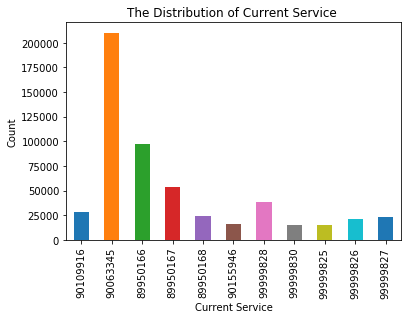

In [8]:
train['current_service'].value_counts(sort=False).plot.bar()
plt.xlabel("Current Service")
plt.ylabel("Count")
plt.title("The Distribution of Current Service ")

Text(0.5,1,'Complaint_Level')

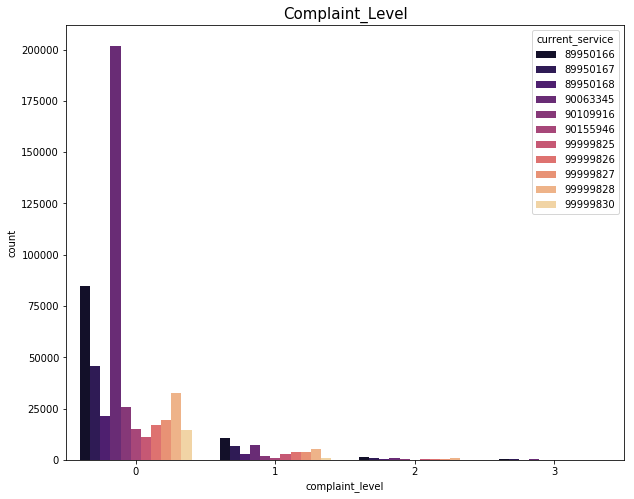

In [10]:
#离散型EDA
import seaborn as sns
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="complaint_level", hue="current_service", data=train,palette = 'magma')
ax.set_title('Complaint_Level',size=15)

由官网数据介绍我们可以知道1代表普通，2代表重要，3代表重大，而0应该是数据缺失未被标记。可见，只有少部分人被标记了complaint_level，并且在其中只有极少数是重要或者重大等级

Text(0.5,1,'Gender')

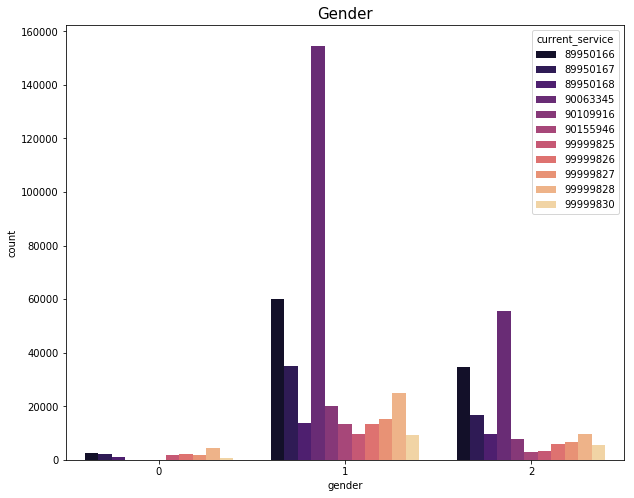

In [14]:
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="gender", hue="current_service", data=train,palette = 'magma',color='y')
ax.set_title('Gender',size=15)

0为缺失值 1为男性 2为女性 期中90063345套餐相对其他套餐更受欢迎 相同套餐男性比女性使用人数更多

Text(0.5,1,'Is_mix_service')

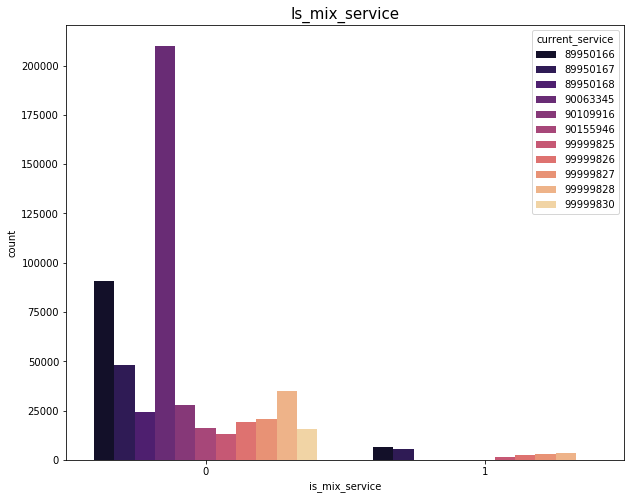

In [15]:
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="is_mix_service", hue="current_service", data=train,palette = 'magma',color='y')
ax.set_title('Is_mix_service',size=15)

是否固移融合套餐 可以看到大多数用户都不是固移融合套餐

Text(0.5,1,'Is_promise_low_consume')

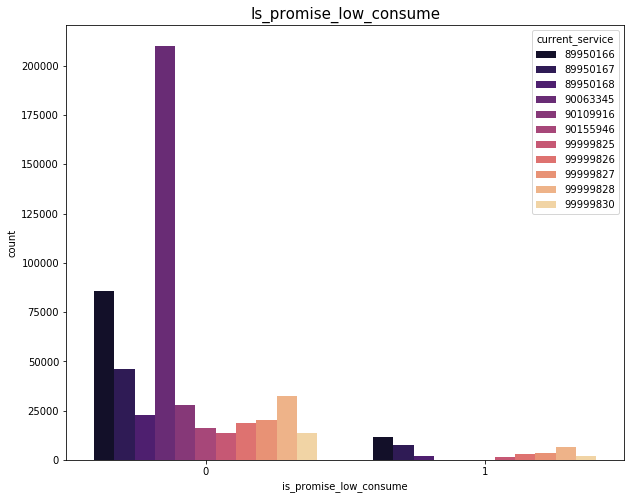

In [17]:
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="is_promise_low_consume", hue="current_service", data=train,palette = 'magma',color='y')
ax.set_title('Is_promise_low_consume',size=15)

1代表承诺低消费用户，0代表不承诺低消费用户。可见绝大多数人都是非承诺低消费用户。承诺用户的套餐多集中于89950166、89950167、99999828，其其套餐金额都在150元以下。这也符合现实常识。

Text(0.5,1,'Many_over_bill')

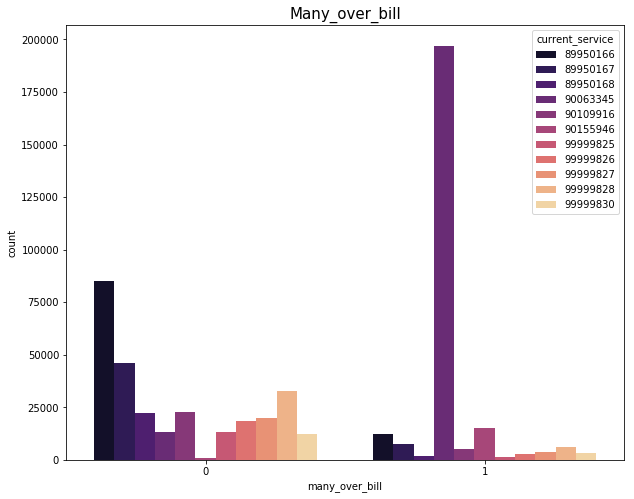

In [18]:
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="many_over_bill", hue="current_service", data=train,palette = 'magma',color='y')
ax.set_title('Many_over_bill',size=15)

0代表不是 1代表超套餐 基本上各个套餐都有超套餐的人  但是90063345基本上有90%的用户都超套餐  腾讯大王卡的特性导致用户一般都会超过套餐内的使用情况

Text(0.5,1,'Service_Type')

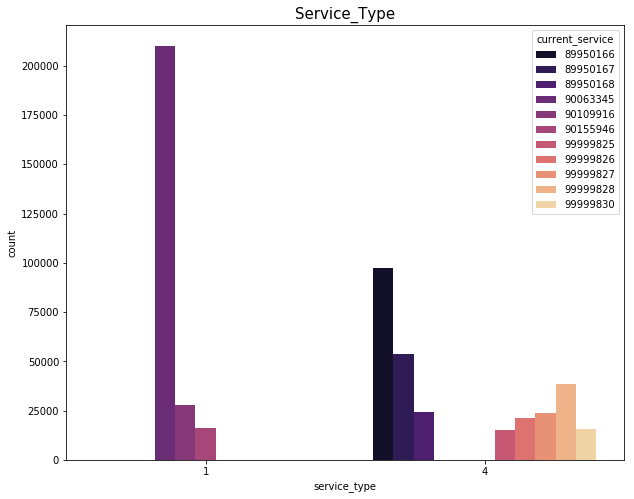

In [20]:
ax=plt.figure(figsize=(10,8)).add_subplot(111)
sns.countplot(x="service_type", hue="current_service", data=train,palette = 'magma',color='y')
ax.set_title('Service_Type',size=15)

0：23G融合，1：2I2C，2：2G，3：3G，4：4G
2I2C:是指与具有互联网线上应用触点，且用户规模上千万的互联网企业开展的合作项目，完全采用电商模式运作。其套餐是中国联通与互联网第三方合作伙伴如腾讯、支付宝、百度等推出的互联网套餐。
基本上只有套餐1和4  没有0 2 3

Text(0.5,1,'The Distribution of Service Type ')

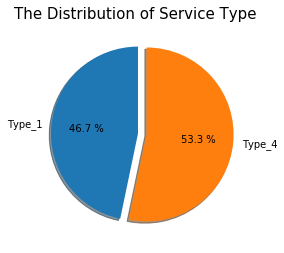

In [7]:
service_type = train.service_type.values
set(service_type)

#统计各种类型的数据个数
count4 = 0
count1 = 0
for i in service_type:
    if i == 4:
        count4+=1
    else:
        count1 +=1
labels = 'Type_1', 'Type_4'
fracs = [count1,count4]
explode = [0, 0.1] # 0.1 凸出这部分，
plt.axes(aspect=1)  # set this , Figure is round, otherwise it is an ellipse
#autopct ，show percet
plt.pie(x=fracs, labels=labels, explode=explode,autopct='%3.1f %%',
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.title('The Distribution of Service Type ', fontsize=15)

In [9]:
type_sort = []
for i in range(len(service_type)):
    type_sort.append([[i],current_service[i]])
type_sort = [[current_service[i],service_type[i]] for i in range(len(current_service))]
type_sort_n = [int(i[0]*10+i[1]) for i in type_sort]
set_type_sort = set(type_sort_n)
str(set_type_sort)

'{899501664, 999998304, 999998274, 901559461, 899501674, 900633451, 999998284, 999998254, 899501684, 999998264, 901099161}'

最后一位数字代表服务类型  
可以看到当前套餐与套餐服务类型有一一对应的关系
1为互联网套餐  4为普通联通套餐

C:\Software\anaconda\ana\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Age Distribution')

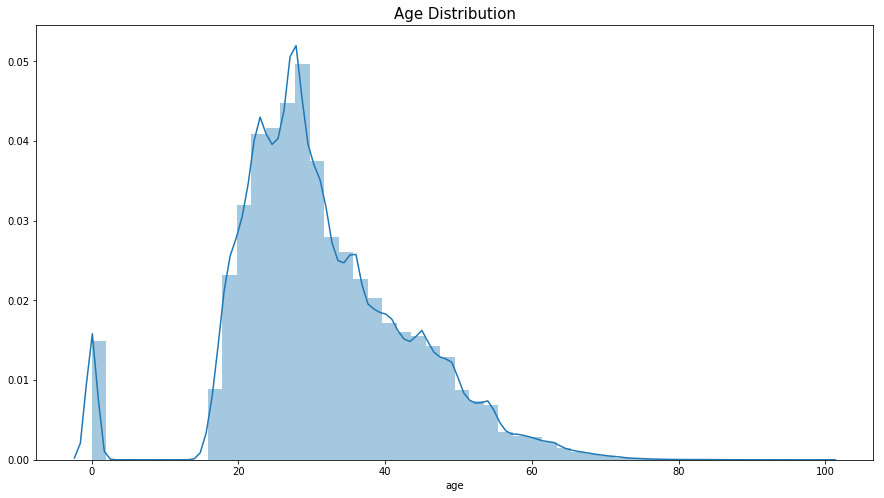

In [12]:
#连续变量EDA
#分析age
plt.subplots(figsize=(15, 8)) 
sns.distplot(train['age'],rug=False) 
plt.title("Age Distribution" ,fontsize=15)

对于年龄来讲，基本上符合电信用户群体的分布，但是有很多0岁的异常值，对于异常值，我们尝试了替换service_typpe字段对应的均值和使用原始值两种方法,最终选取了原始值.

C:\Software\anaconda\ana\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Age & Service Type Distribution')

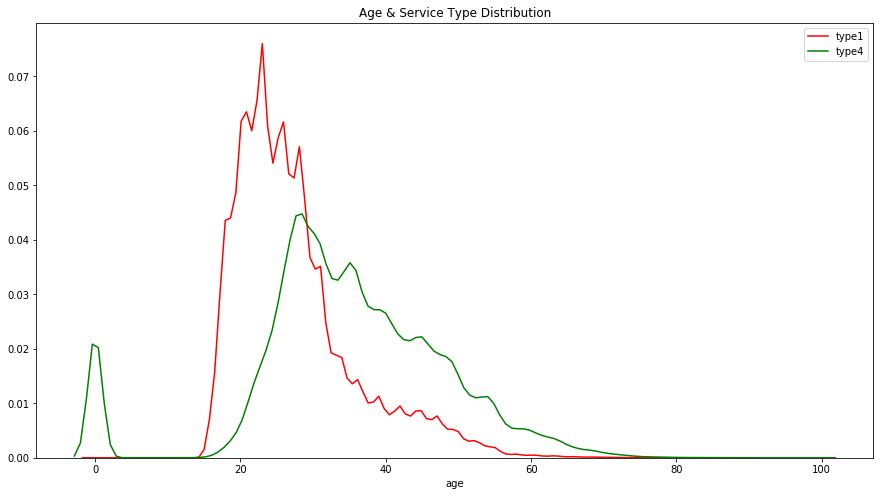

In [13]:
plt.subplots(figsize=(15, 8)) 
k1=sns.distplot(train[train.service_type==1].age,hist=False,color='r',label='type1') 
k2=sns.distplot(train[train.service_type==4].age,hist=False,color='g',label='type4')
plt.title('Age & Service Type Distribution')

可以看到，使用套餐类型为1的用户多集中于青少年，使用套餐类型为4的用户多集中于中年
进一步验证套餐类型1应该为互联网套餐，4为普通套餐

D:\anocanda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'online_time')

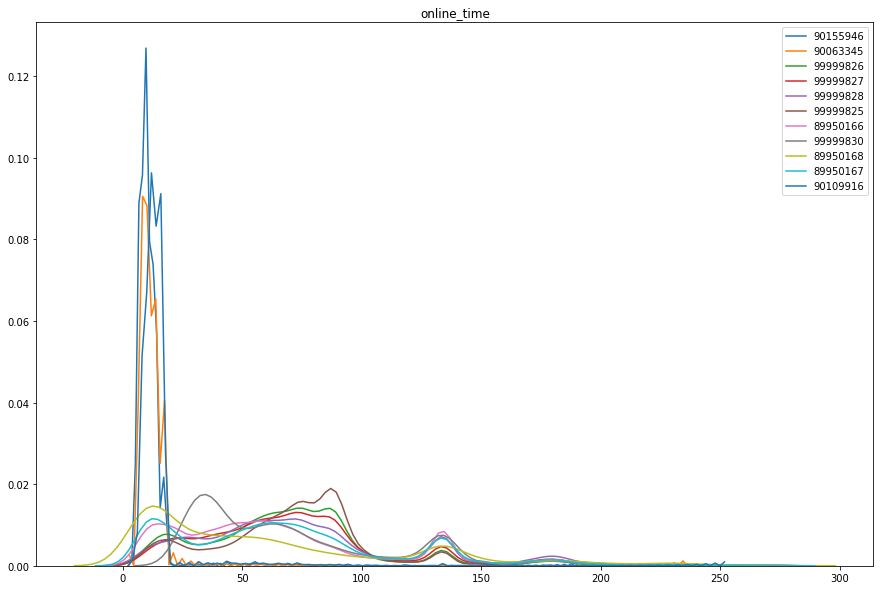

In [31]:
#online_time
plt.subplots(figsize=(15, 10)) 
service_name=[90155946, 90063345, 99999826, 99999827, 99999828, 99999825, 89950166, 99999830, 89950168, 89950167, 90109916]
for name in service_name:
    sns.kdeplot(train[train.current_service==name]["online_time"],label=name)
plt.title("online_time")

Text(0.5,1,'The Distribution of 1_Total_Fee ')

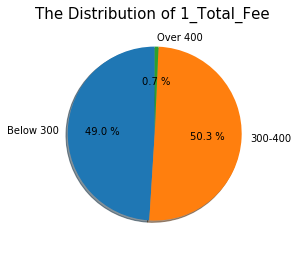

In [41]:
#1_total_fee
money1=0
money2=0
money3=0
fee1 = train['1_total_fee'].values
for i in fee1:
    if i<=300:
        money1+=1
    if i>=400:
        money3+=1
    else:
        money2+=1
labels = 'Below 300', '300-400','Over 400'
fracs = [money1,money2,money3]
plt.axes(aspect=1)  # set this , Figure is round, otherwise it is an ellipse
#autopct ，show percet
plt.pie(x=fracs, labels=labels,autopct='%3.1f %%',
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.title('The Distribution of 1_Total_Fee ', fontsize=15)

每个月缴费的情况分布基本类似，在0-400元段集中了近百分之九十九的用户，费用超过400RMB的不足百分之一。

Text(0.5,1,'Correlation Coefficient ')

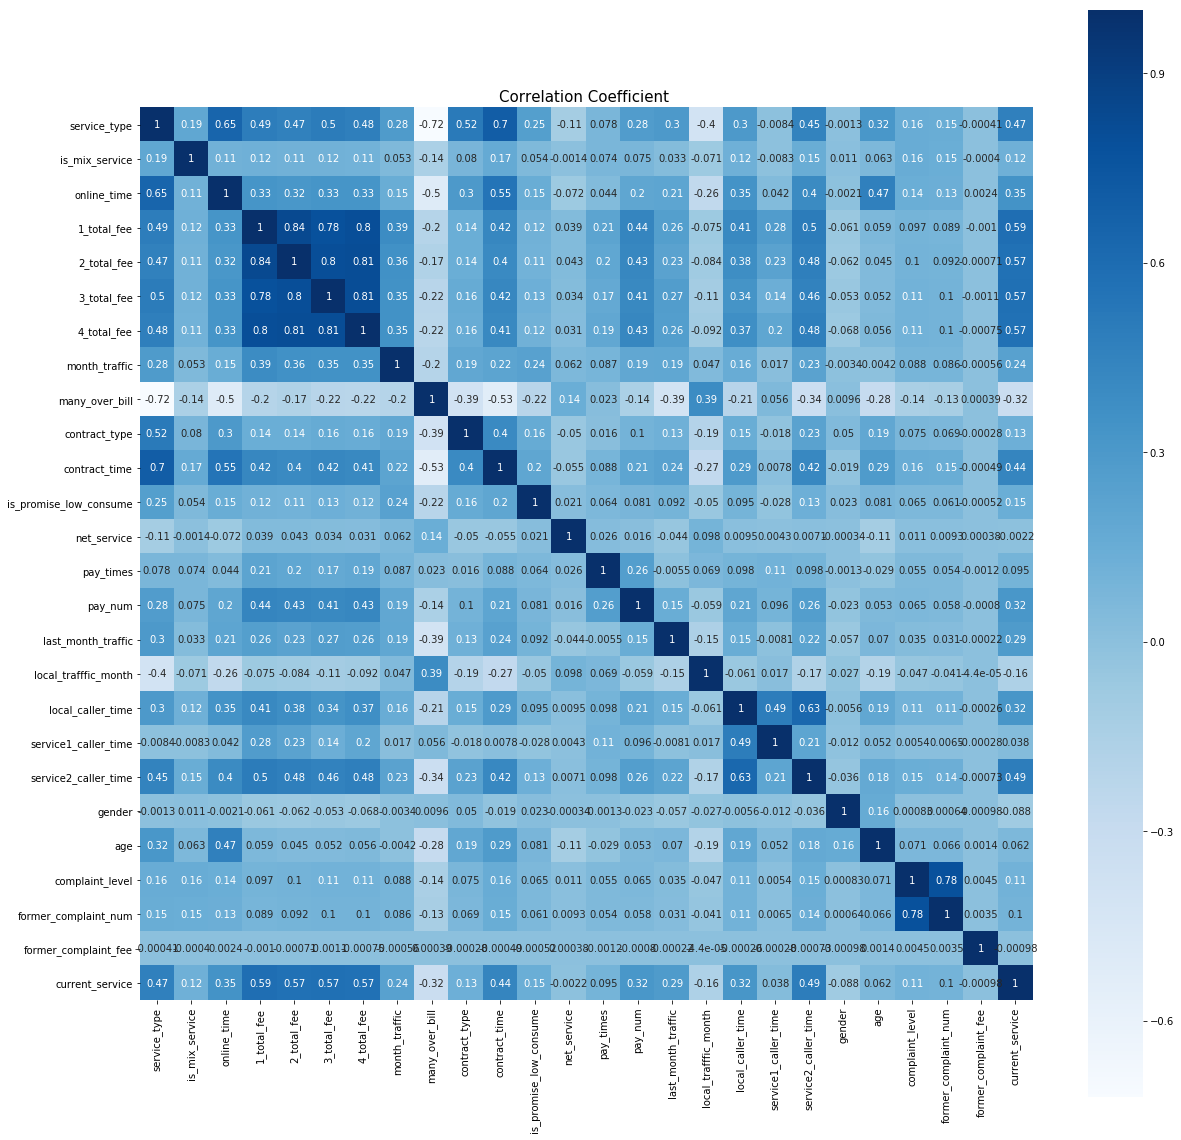

In [10]:
import seaborn as sns
dfData=train.corr()
plt.subplots(figsize=(20, 20)) # 设置画面大小
sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
plt.title("Correlation Coefficient " ,fontsize=15)

可以看到total_fee之间有非常强的相关性 
current_service与total_fee的相关性最强